In [1]:
#Este trabalho tem como objetivo reproduzir a FIG. 13 do artigo DESI DR2, página 26.
#Referências: 
             #[1] "DESI DR2 Results II: Measurements of Baryon Acoustic Oscillations and Cosmological Constraints" (https://arxiv.org/abs/2503.14738)
             #[2] "Planck 2018 results. VI. Cosmological parameters" (http://arxiv.org/abs/1807.06209)
             #[3] "The Dark Energy Survey: Cosmology Results With ∼1500 New High-redshift Type Ia Supernovae Using The Full 5-year Dataset" (https://arxiv.org/pdf/2401.02929)
#Dados para as barras de erro estão disponíveis em: https://github.com/CobayaSampler/bao_data/tree/master/desi_bao_dr2
                                                    #desi_gaussian_bao_ALL_GCcomb_cov.txt
                                                    #desi_gaussian_bao_ALL_GCcomb_mean.txt

In [1]:
# CAMB LateDE
import numpy as np
import matplotlib.pyplot as plt
import camb, os, sys

#Check which CAMB is installed
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.5.0 installed at /home/paula/Projeto_LateDE/camb-env/lib/python3.12/site-packages/camb


In [2]:
c = 299792.458  # km/s

In [3]:
#Fiducial: ΛCDM do Planck 2018

latede_cosmology_fid = camb.set_params(# Background
                            H0 = 67.27, ombh2=0.02236, omch2=0.12091, TCMB = 2.7255,
                            dark_energy_model = 'ppf',
                            DEmodel = 1,
                            w0 =-1.0, 
                            # Neutrinos
                            omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                            nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                            # Initial Power Spectrum
                            As = 2.100549e-09, ns = 0.9660499, 
                            YHe = 0.246, WantTransfer=True)

In [4]:
# Executar o cálculo
results = camb.get_results(latede_cosmology_fid)

# Intervalo de redshift
z_fid = np.logspace(np.log10(0.02), np.log10(3), 100)

# Distâncias e parâmetros derivados
DA_fid = results.angular_diameter_distance(z_fid)  # [Mpc]
H_fid  = results.hubble_parameter(z_fid)            # [km/s/Mpc]
r_s_fid      = results.get_derived_params()['rdrag']        # [Mpc]

DM_fid = (results.comoving_radial_distance(z_fid))

# Distâncias normalizadas
DMfid = DM_fid / r_s_fid
DHfid = (c / H_fid) / r_s_fid
DVfid = (( DM_fid**2 * (c*z_fid)/H_fid )**(1/3)) / r_s_fid  

In [5]:
#Gráfico para D_V

#DESI com barras de erro (a)
#ΛCDM: CMB (b)
#ΛCDM: DESY5 (c)
#ΛCDM: DESI (d)
#ΛCDM: DESI+CMB (e)

In [6]:
#DESI com barras de erro (a)

mean_file = "desi_gaussian_bao_ALL_GCcomb_mean.txt"
cov_file  = "desi_gaussian_bao_ALL_GCcomb_cov.txt"

# -------------------------------------------
# 1. Carregar matriz de covariância (13×13)
# -------------------------------------------
cov = np.loadtxt(cov_file)

# erros = sqrt da diagonal
errors = np.sqrt(np.diag(cov))

# -------------------------------------------
# 2. Carregar dados médios (lendo linha a linha)
# -------------------------------------------
data = []
with open(mean_file, "r") as f:
    for line in f:
        if not line.startswith("#"):
            z, value, quantity = line.split()
            data.append([float(z), float(value), quantity])

data = np.array(data, dtype=object)

# -------------------------------------------
# 3. Filtrar apenas DV_over_rs
# -------------------------------------------
mask_DV = data[:,2] == "DV_over_rs"

z_DV  = data[mask_DV][:,0].astype(float)   # redshift
DV    = data[mask_DV][:,1].astype(float)   # DV/rs valores
err_DV = errors[mask_DV]                   # erros correspondentes

# debug opcional:
print("z_DV =", z_DV)
print("DV =", DV)
print("err_DV =", err_DV)

z_DV = [0.295]
DV = [7.94167639]
err_DV = [0.07609196]


In [7]:
#Cálculo dos demais pontod D_V

mean_file = "desi_gaussian_bao_ALL_GCcomb_mean.txt"
cov_file  = "desi_gaussian_bao_ALL_GCcomb_cov.txt"

# ------------------------------------------------------
# 1. Ler matriz de covariância (13x13)
# ------------------------------------------------------
cov = np.loadtxt(cov_file)
errors = np.sqrt(np.diag(cov))

# ------------------------------------------------------
# 2. Ler arquivo mean linha a linha
# ------------------------------------------------------
data = []

with open(mean_file, "r") as f:
    for line in f:
        line = line.strip()
        if line == "" or line.startswith("#"):
            continue
        z_str, val_str, tag = line.split()
        data.append([float(z_str), float(val_str), tag])

data = np.array(data, dtype=object)

# ------------------------------------------------------
# 3. Separar DM, DH
# ------------------------------------------------------
mask_DM = data[:,2] == "DM_over_rs"
mask_DH = data[:,2] == "DH_over_rs"

z_DM   = data[mask_DM][:,0].astype(float)
DM     = data[mask_DM][:,1].astype(float)
err_DM = errors[mask_DM]

z_DH   = data[mask_DH][:,0].astype(float)
DH     = data[mask_DH][:,1].astype(float)
err_DH = errors[mask_DH]

# ------------------------------------------------------
# 4. Calcular DV/rs = ( z * DM^2 * DH )^(1/3)
# ------------------------------------------------------
DV_calc = (z_DM * DM**2 * DH)**(1/3)

# ------------------------------------------------------
# 5. Propagação de erros (cov DM-DH = 0 no DESI)
# ------------------------------------------------------
dDV_dDM = (2/3) * (DV_calc / DM)
dDV_dDH = (1/3) * (DV_calc / DH)

sigma_DM = err_DM
sigma_DH = err_DH

sigma_DV = np.sqrt(
    (dDV_dDM * sigma_DM)**2 +
    (dDV_dDH * sigma_DH)**2
)

# ------------------------------------------------------
# 6. Imprimir tabela
# ------------------------------------------------------
print("Tabela de DV/rs com propagação de erros\n")
print(" z      |   DV/rs    |  erro")
print("--------------------------------------")
for zi, dvi, ei in zip(z_DM, DV_calc, sigma_DV):
    print(f"{zi:6.3f} | {dvi:10.6f} | {ei:10.6f}")


Tabela de DV/rs com propagação de erros

 z      |   DV/rs    |  erro
--------------------------------------
 0.510 |  12.720996 |   0.134022
 0.706 |  16.050643 |   0.144026
 0.934 |  19.721345 |   0.123819
 1.321 |  24.253110 |   0.229231
 1.484 |  26.064712 |   0.558920
 2.330 |  31.268667 |   0.309356


In [8]:
#ΛCDM: CMB (b)

latede_cosmology_b = camb.set_params(# Background
                            H0 = 67.14, ombh2=0.02236, omch2=0.1204, TCMB = 2.7255,
                            dark_energy_model = 'ppf',
                            DEmodel = 1,
                            w0 =-1.0,
                            # Neutrinos
                            omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                            nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                            # Initial Power Spectrum
                            As = 2.100549e-09, ns = 0.9660499, 
                            YHe = 0.246, WantTransfer=True)

In [9]:
# Executar o cálculo
results = camb.get_results(latede_cosmology_b)

# Intervalo de redshift
z_LCDM_b = np.logspace(np.log10(0.02), np.log10(3), 100)

# Distâncias e parâmetros derivados
DAb_LCDM = results.angular_diameter_distance(z_LCDM_b)   # [Mpc]
Hb_LCDM  = results.hubble_parameter(z_LCDM_b)            # [km/s/Mpc]
r_s_b    = results.get_derived_params()['rdrag']         # [Mpc]

# Distância comoving radial em Mpc (não normalizada)
DM_b = results.comoving_radial_distance(z_LCDM_b)        # [Mpc]

# Distâncias normalizadas
DMb = DM_b / r_s_b                                       # D_M / r_s
DHb = (c / Hb_LCDM) / r_s_b                              # D_H / r_s
DVb = ((DM_b**2 * (c*z_LCDM_b) / Hb_LCDM)**(1/3)) / r_s_b   # D_V / r_s


In [10]:
#ΛCDM: DESY5 (c) (Não consta na TABLE V da Referência [1], então utilizei H_0 DESI+CMB e w_c=0.1369 que se aproximou mais do resultado do gráfico original)

latede_cosmology_c = camb.set_params(# Background
                            H0 = 68.17, ombh2=0.02236, omch2=0.1369, TCMB = 2.7255,
                            dark_energy_model = 'ppf',
                            DEmodel = 1,
                            w0 =-1.0,
                            # Neutrinos
                            omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                            nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                            # Initial Power Spectrum
                            As = 2.100549e-09, ns = 0.9660499, 
                            YHe = 0.246, WantTransfer=True)

In [11]:
# Executar o cálculo
results = camb.get_results(latede_cosmology_c)

# Intervalo de redshift
z_LCDM_c = np.logspace(np.log10(0.02), np.log10(3), 100)

# Distâncias e parâmetros derivados
DAc_LCDM = results.angular_diameter_distance(z_LCDM_c)   # [Mpc]
Hc_LCDM  = results.hubble_parameter(z_LCDM_c)            # [km/s/Mpc]
r_s_c    = results.get_derived_params()['rdrag']         # [Mpc]

# Distância comoving radial em Mpc (não normalizada)
DM_c = results.comoving_radial_distance(z_LCDM_c)        # [Mpc]

# Distâncias normalizadas
DMc = DM_c / r_s_c                                       # D_M / r_s
DHc = (c / Hc_LCDM) / r_s_c                              # D_H / r_s
DVc = ((DM_c**2 * (c*z_LCDM_c) / Hc_LCDM)**(1/3)) / r_s_c   # D_V / r_s

In [12]:
#ΛCDM: DESI (d) (Na falta do valor de H_0, utilizei H_0 de DESI+CMB)

latede_cosmology_d = camb.set_params(# Background
                            H0 = 68.17, ombh2=0.02236, omch2=0.1125, TCMB = 2.7255,
                            dark_energy_model = 'ppf',
                            DEmodel = 1,
                            w0 =-1.0,
                            # Neutrinos
                            omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                            nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                            # Initial Power Spectrum
                            As = 2.100549e-09, ns = 0.9660499, 
                            YHe = 0.246, WantTransfer=True)

In [13]:
# Executar o cálculo
results = camb.get_results(latede_cosmology_d)

# Intervalo de redshift
z_LCDM_d = np.logspace(np.log10(0.02), np.log10(3), 100)

# Distâncias e parâmetros derivados
DAd_LCDM = results.angular_diameter_distance(z_LCDM_d)   # [Mpc]
Hd_LCDM  = results.hubble_parameter(z_LCDM_d)            # [km/s/Mpc]
r_s_d    = results.get_derived_params()['rdrag']         # [Mpc]

# Distância comoving radial em Mpc (não normalizada)
DM_d = results.comoving_radial_distance(z_LCDM_d)        # [Mpc]

# Distâncias normalizadas
DMd = DM_d / r_s_d                                       # D_M / r_s
DHd = (c / Hd_LCDM) / r_s_d                              # D_H / r_s
DVd = ((DM_d**2 * (c*z_LCDM_d) / Hd_LCDM)**(1/3)) / r_s_d   # D_V / r_s

In [14]:
#ΛCDM: DESI+CMB (e)

latede_cosmology_e = camb.set_params(# Background
                            H0 = 68.17, ombh2=0.02236, omch2=0.1182, TCMB = 2.7255,
                            dark_energy_model = 'ppf',
                            DEmodel = 1,
                            w0 =-1.0,
                            # Neutrinos
                            omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                            nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                            # Initial Power Spectrum
                            As = 2.100549e-09, ns = 0.9660499, 
                            YHe = 0.246, WantTransfer=True)

In [15]:
# Executar o cálculo
results = camb.get_results(latede_cosmology_e)

# Intervalo de redshift
z_LCDM_e = np.logspace(np.log10(0.02), np.log10(3), 100)

# Distâncias e parâmetros derivados
DAe_LCDM = results.angular_diameter_distance(z_LCDM_e)   # [Mpc]
He_LCDM  = results.hubble_parameter(z_LCDM_e)            # [km/s/Mpc]
r_s_e    = results.get_derived_params()['rdrag']         # [Mpc]

# Distância comoving radial em Mpc (não normalizada)
DM_e = results.comoving_radial_distance(z_LCDM_e)        # [Mpc]

# Distâncias normalizadas
DMe = DM_e / r_s_e                                       # D_M / r_s
DHe = (c / He_LCDM) / r_s_e                              # D_H / r_s
DVe = ((DM_e**2 * (c*z_LCDM_e) / He_LCDM)**(1/3)) / r_s_e   # D_V / r_s

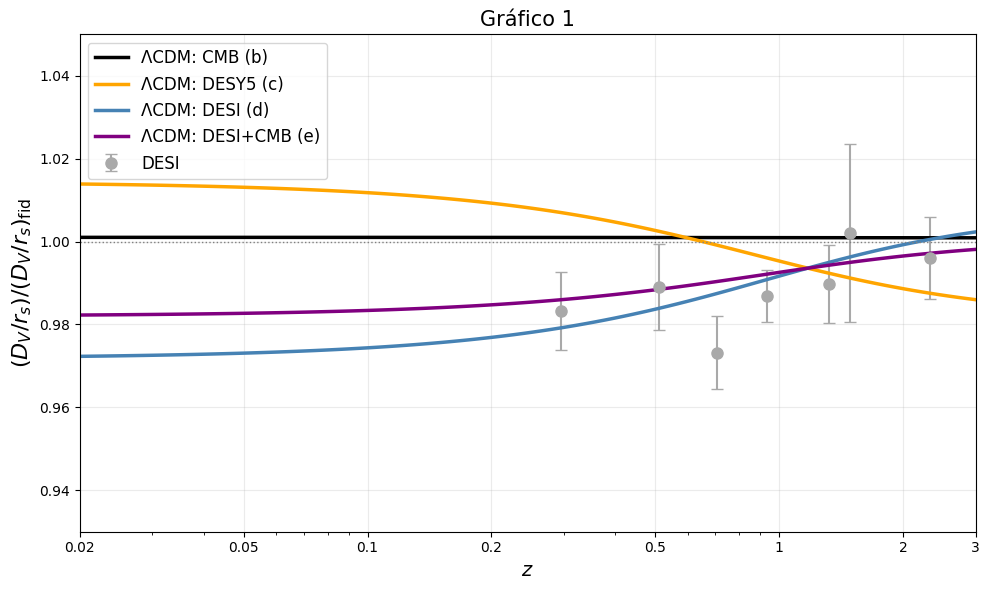

In [16]:
# Gráfico para D_V

plt.figure(figsize=(10,6))

# =======================
# 1. Normalização fiducial
# =======================

DVfid_norm = DVfid     # já é D_V / r_s

# ================================================
# (A) PONTO ÚNICO D_V DO ARQUIVO — OBSERVADO
# ================================================

# Renomear corretamente:
DV_obs     = DV       # (o único valor lido do arquivo DESI)
err_DV_obs = err_DV   # (a incerteza correspondente)
z_DV_obs   = z_DV        # redshift do ponto único

# Interpolação no fiducial
DVfid_obs_interp = np.interp(z_DV_obs, z_fid, DVfid)

# Normalização
DV_obs_ratio     = DV_obs / DVfid_obs_interp
DV_obs_err_ratio = err_DV_obs / DVfid_obs_interp

# Plotar o ponto único D_V observado
plt.errorbar(
    z_DV_obs, DV_obs_ratio,
    yerr=DV_obs_err_ratio,
    fmt='o',
    color='darkgray',
    ecolor='darkgray',
    markersize=8,
    capsize=4,
    elinewidth=1.5
)

# ================================================
# (B) D_V CALCULADO A PARTIR DE D_M E D_H
# ================================================

DVfid_calc_interp = np.interp(z_DM, z_fid, DVfid)

DVfid_calc_interp = np.interp(z_DM, z_fid, DVfid)

DV_calc_ratio     = DV_calc / DVfid_calc_interp
DV_calc_err_ratio = sigma_DV / DVfid_calc_interp

plt.errorbar(
    z_DM,
    DV_calc_ratio,
    yerr=DV_calc_err_ratio,
    fmt='o',
    color='darkgray',
    ecolor='darkgray',
    markersize=8,
    elinewidth=1.5,
    capsize=4,
    label="DESI"
)

# Interpolar o DVfid para cada cosmologia:
DVfid_interp_b = np.interp(z_LCDM_b, z_fid, DVfid)
DVfid_interp_c = np.interp(z_LCDM_c, z_fid, DVfid)
DVfid_interp_d = np.interp(z_LCDM_d, z_fid, DVfid)
DVfid_interp_e = np.interp(z_LCDM_e, z_fid, DVfid)

# Agora sim: plot correto
plt.plot(z_LCDM_b, DVb / DVfid_interp_b, label='ΛCDM: CMB (b)', color='black', linewidth=2.5)
plt.plot(z_LCDM_c, DVc / DVfid_interp_c, label='ΛCDM: DESY5 (c)', color='orange', linewidth=2.5)
plt.plot(z_LCDM_d, DVd / DVfid_interp_d, label='ΛCDM: DESI (d)', color='steelblue', linewidth=2.5)
plt.plot(z_LCDM_e, DVe / DVfid_interp_e, label='ΛCDM: DESI+CMB (e)', color='purple', linewidth=2.5)

# =======================
# 4. Aparência do gráfico
# =======================

plt.axhline(1.0, color='gray', linestyle=':', linewidth=1)
plt.xscale('log')

plt.title('Gráfico 1', fontsize=15)

plt.xticks([0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 3],
           ['0.02', '0.05', '0.1', '0.2', '0.5', '1', '2', '3'])

plt.xlabel(r'$z$', fontsize=14)
plt.ylabel(r'$(D_V/r_s) / (D_V/r_s)_{\rm fid}$', fontsize=16)

plt.xlim(0.02, 3)
plt.ylim(0.93, 1.05)

plt.grid(alpha=0.25)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [18]:
#Gráfico para D_M

#DESI com barras de erro (f)
#wCDM: DESI+CMB+DESY5 (g)
#w0waCDM: DESI+DESY5 (h)
#w0waCDM: DESI+CMB+DESY5 (i)

In [19]:
#DESI com barras de erro (f) 
import numpy as np
import matplotlib.pyplot as plt

mean_file = "desi_gaussian_bao_ALL_GCcomb_mean.txt"
cov_file  = "desi_gaussian_bao_ALL_GCcomb_cov.txt"

# -------------------------------------------
# 1. Carregar matriz de covariância (13×13)
# -------------------------------------------
cov = np.loadtxt(cov_file)

# erros = sqrt da diagonal
errors = np.sqrt(np.diag(cov))

# -------------------------------------------
# 2. Carregar dados médios (lendo linha a linha)
# -------------------------------------------
data = []
with open(mean_file, "r") as f:
    for line in f:
        if not line.startswith("#"):
            z, value, quantity = line.split()
            data.append([float(z), float(value), quantity])

data = np.array(data, dtype=object)

# -------------------------------------------
# 3. Filtrar apenas DM_over_rs
# -------------------------------------------
mask_DM = data[:,2] == "DM_over_rs"

z_DM  = data[mask_DM][:,0].astype(float)   # redshift
DM    = data[mask_DM][:,1].astype(float)   # DM/rs valores
err_DM = errors[mask_DM]                   # erros correspondentes

# debug opcional:
print("z_DM =", z_DM)
print("DM =", DM)
print("err_DM =", err_DM)

z_DM = [0.51  0.706 0.934 1.321 1.484 2.33 ]
DM = [13.58758434 17.35069094 21.57563956 27.60085612 30.51190063 38.98897396]
err_DM = [0.16836678 0.17993122 0.16178159 0.32455588 0.76355764 0.53168203]


In [20]:
#wCDM: DESI+CMB+DESY5 (g)

latede_cosmology_g = camb.set_params(# Background
                            H0 = 67.34, ombh2=0.022336, omch2=0.1180, TCMB = 2.7255,
                            dark_energy_model = 'ppf',
                            DEmodel = 1,
                            w0 =-0.961, 
                            # Neutrinos
                            omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                            nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                            # Initial Power Spectrum
                            As = 2.100549e-09, ns = 0.9660499, 
                            YHe = 0.246, WantTransfer=True)

In [21]:
# Executar o cálculo
results = camb.get_results(latede_cosmology_g)

# Intervalo de redshift
z_w0wa_g = np.logspace(np.log10(0.02), np.log10(3), 100)

# Distâncias e parâmetros derivados
DAg_w0wa = results.angular_diameter_distance(z_w0wa_g)   # [Mpc]
Hg_w0wa  = results.hubble_parameter(z_w0wa_g)            # [km/s/Mpc]
r_s_g    = results.get_derived_params()['rdrag']         # [Mpc]

# Distância comoving radial em Mpc (não normalizada)
DM_g = results.comoving_radial_distance(z_w0wa_g)        # [Mpc]

# Distâncias normalizadas
DMg = DM_g / r_s_g                                        # D_M / r_s
DHg = (c / Hg_w0wa) / r_s_g                               # D_H / r_s
DVg = ((DM_g**2 * (c*z_w0wa_g) / Hg_w0wa)**(1/3)) / r_s_g # D_V / r_s

In [22]:
#w0waCDM: DESI+DESY5 (h) (Na falta do valor de H_0, utilizei H_0 de DESI+CMB+DESY5 (i))

latede_cosmology_h = camb.set_params(# Background
                            H0 = 66.74, ombh2=0.022336, omch2=0.1198, TCMB = 2.7255,
                            dark_energy_model = 'ppf',
                            DEmodel = 2,
                            w0 =-0.752, w1 =-0.86, 
                            # Neutrinos
                            omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                            nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                            # Initial Power Spectrum
                            As = 2.100549e-09, ns = 0.9660499, 
                            YHe = 0.246, WantTransfer=True)

In [23]:
# Executar o cálculo
results = camb.get_results(latede_cosmology_h)

# Intervalo de redshift
z_w0wa_h = np.logspace(np.log10(0.02), np.log10(3), 100)

# Distâncias e parâmetros derivados
DAh_w0wa = results.angular_diameter_distance(z_w0wa_h)   # [Mpc]
Hh_w0wa  = results.hubble_parameter(z_w0wa_h)            # [km/s/Mpc]
r_s_h    = results.get_derived_params()['rdrag']         # [Mpc]

# Distância comoving radial: D_M = (1+z) * D_A
DM_h = (1 + z_w0wa_h) * DAh_w0wa                         # [Mpc]

# Distâncias normalizadas por r_s
DMh = DM_h / r_s_h                                       # D_M / r_s
DHh = (c / Hh_w0wa) / r_s_h                              # D_H / r_s
DVh = ((DM_h**2 * (c*z_w0wa_h) / Hh_w0wa)**(1/3)) / r_s_h   # D_V / r_s

In [24]:
#w0waCDM: DESI+CMB+DESY5 (i)

latede_cosmology_i = camb.set_params(# Background
                            H0 = 66.74, ombh2=0.022336, omch2=0.1196, TCMB = 2.7255,
                            dark_energy_model = 'ppf',
                            DEmodel = 2,
                            w0 =-0.758, w1 =-0.82, 
                            # Neutrinos
                            omnuh2 = 0, num_nu_massless=3.044, num_nu_massive = 0,
                            nu_mass_degeneracies=[0], nu_mass_numbers = [0],
                            # Initial Power Spectrum
                            As = 2.100549e-09, ns = 0.9660499, 
                            YHe = 0.246, WantTransfer=True)

In [25]:
# Executar o cálculo
results = camb.get_results(latede_cosmology_i)

# Intervalo de redshift
z_w0wa_i = np.logspace(np.log10(0.02), np.log10(3), 100)

# Distâncias e parâmetros derivados
DAi_w0wa = results.angular_diameter_distance(z_w0wa_i)   # [Mpc]
Hi_w0wa  = results.hubble_parameter(z_w0wa_i)            # [km/s/Mpc]
r_s_i    = results.get_derived_params()['rdrag']         # [Mpc]

# Distância comoving radial (D_M) em Mpc
DM_i = results.comoving_radial_distance(z_w0wa_i)        # [Mpc]

# Distâncias normalizadas
DMi = DM_i / r_s_i                                   # D_M / r_s
DHi = (c / Hi_w0wa) / r_s_i                          # D_H / r_s
DVi = ((DM_i**2 * (c*z_w0wa_i) / Hi_w0wa)**(1/3)) / r_s_i   # D_V / r_s

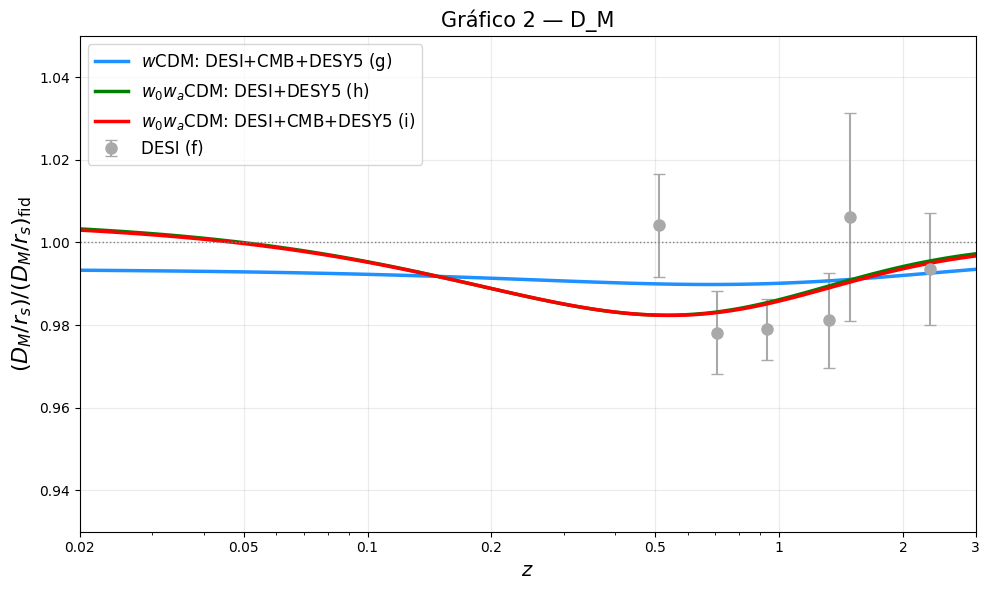

In [27]:
# ==========================================
# Gráfico para D_M — CORRIGIDO
# ==========================================

plt.figure(figsize=(10,6))

# ==========================================
# 1. Normalização fiducial (D_M fiducial)
# ==========================================

DMfid_norm = DMfid   # DMfid = D_M_fid / r_s_fid

# Interpolar o fiducial nos pontos dos dados DESI
DMfid_interp_DESI = np.interp(z_DM, z_fid, DMfid)

# Razão observação / modelo fiducial
DM_ratio     = DM / DMfid_interp_DESI
DM_err_ratio = err_DM / DMfid_interp_DESI

# ==========================================
# 2. Pontos observacionais DESI
# ==========================================

plt.errorbar(
    z_DM, DM_ratio,
    yerr=DM_err_ratio,
    fmt='o',
    color='darkgray',
    ecolor='darkgray',
    markersize=8,
    capsize=4,
    elinewidth=1.5,
    label='DESI (f)'
)

# ==========================================
# 3. Modelos — CORRIGIDOS
# ==========================================

# Interpolações corretas do fiducial para cada cosmologia
DMfid_interp_g = np.interp(z_w0wa_g, z_fid, DMfid)
DMfid_interp_h = np.interp(z_w0wa_h, z_fid, DMfid)
DMfid_interp_i = np.interp(z_w0wa_i, z_fid, DMfid)

# Razões corretas
DMg_ratio = DMg / DMfid_interp_g
DMh_ratio = DMh / DMfid_interp_h
DMi_ratio = DMi / DMfid_interp_i

# Curvas corrigidas
plt.plot(z_w0wa_g, DMg_ratio,
         label=r'$w$CDM: DESI+CMB+DESY5 (g)', color='dodgerblue', linewidth=2.5)

plt.plot(z_w0wa_h, DMh_ratio,
         label=r'$w_0w_a$CDM: DESI+DESY5 (h)', color='green', linewidth=2.5)

plt.plot(z_w0wa_i, DMi_ratio,
         label=r'$w_0w_a$CDM: DESI+CMB+DESY5 (i)', color='red', linewidth=2.5)

# ==========================================
# 4. Aparência
# ==========================================

plt.axhline(1.0, color='gray', linestyle=':', linewidth=1)
plt.xscale('log')

plt.xticks([0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 3],
           ['0.02', '0.05', '0.1', '0.2', '0.5', '1', '2', '3'])

plt.xlabel(r'$z$', fontsize=14)
plt.ylabel(r'$(D_M/r_s)/(D_M/r_s)_{\rm fid}$', fontsize=16)

plt.xlim(0.02, 3)
plt.ylim(0.93, 1.05)

plt.title('Gráfico 2 — D_M', fontsize=15)
plt.grid(alpha=0.25)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [27]:
#Gráfico para D_H

#DESI com barras de erro (j)
#wCDM: DESI+CMB+DESY5 (g)
#w0waCDM: DESI+DESY5 (h)
#w0waCDM: DESI+CMB+DESY5 (i)

In [28]:
#DESI com barras de erro (j) 

mean_file = "desi_gaussian_bao_ALL_GCcomb_mean.txt"
cov_file  = "desi_gaussian_bao_ALL_GCcomb_cov.txt"

# -------------------------------------------
# 1. Carregar matriz de covariância (13×13)
# -------------------------------------------
cov = np.loadtxt(cov_file)

# erros = sqrt da diagonal
errors = np.sqrt(np.diag(cov))

# -------------------------------------------
# 2. Carregar dados médios (lendo linha a linha)
# -------------------------------------------
data = []
with open(mean_file, "r") as f:
    for line in f:
        if not line.startswith("#"):
            z, value, quantity = line.split()
            data.append([float(z), float(value), quantity])

data = np.array(data, dtype=object)

# -------------------------------------------
# 3. Filtrar apenas DH_over_rs
# -------------------------------------------
mask_DH = data[:, 2] == "DH_over_rs"

z_DH  = data[mask_DH][:, 0].astype(float)   # redshift
DH    = data[mask_DH][:, 1].astype(float)   # DH/rs valores
err_DH = errors[mask_DH]                    # erros correspondentes

# Debug opcional
print("z_DH =", z_DH)
print("DH =", DH)
print("err_DH =", err_DH)

z_DH = [0.51  0.706 0.934 1.321 1.484 2.33 ]
DH = [21.86294686 19.45534918 17.64149464 14.17602155 12.81699964  8.63154567]
err_DH = [0.42886832 0.33387003 0.20104325 0.22455135 0.51801177 0.10106245]


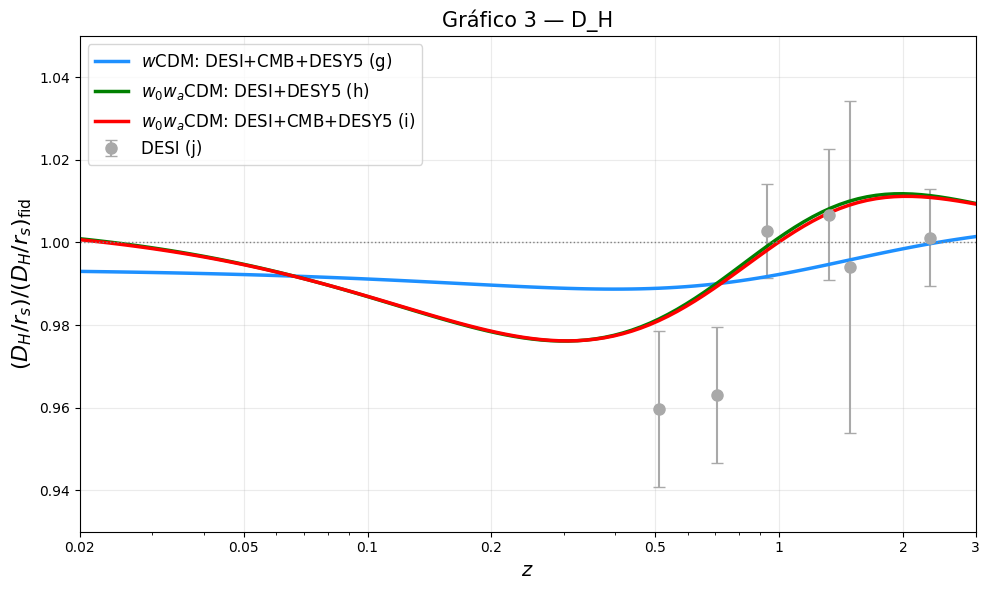

In [29]:
# ==========================================
# Gráfico para D_H — CORRIGIDO
# ==========================================

plt.figure(figsize=(10,6))

# ==========================================
# 1. Normalização fiducial (D_H fiducial)
# ==========================================

DHfid_norm = DHfid   # DHfid = D_H_fid / r_s_fid

# interpolar DHfid para os redshifts dos dados do DESI
DHfid_interp_DESI = np.interp(z_DH, z_fid, DHfid)

# Razão observação / fiducial
DH_ratio     = DH / DHfid_interp_DESI
DH_err_ratio = err_DH / DHfid_interp_DESI

# ==========================================
# 2. Dados DESI (modelo j)
# ==========================================

plt.errorbar(
    z_DH, DH_ratio,
    yerr=DH_err_ratio,
    fmt='o',
    color='darkgray',
    ecolor='darkgray',
    markersize=8,
    capsize=4,
    elinewidth=1.5,
    label='DESI (j)'
)

# ==========================================
# 3. Modelos — CORRIGIDOS
# ==========================================

# Interpolar o fiducial para cada conjunto de z dos modelos
DHfid_interp_g = np.interp(z_w0wa_g, z_fid, DHfid)
DHfid_interp_h = np.interp(z_w0wa_h, z_fid, DHfid)
DHfid_interp_i = np.interp(z_w0wa_i, z_fid, DHfid)

# Razões corretas
DHg_ratio = DHg / DHfid_interp_g
DHh_ratio = DHh / DHfid_interp_h
DHi_ratio = DHi / DHfid_interp_i

# Curvas corrigidas
plt.plot(z_w0wa_g, DHg_ratio,
         label=r'$w$CDM: DESI+CMB+DESY5 (g)', color='dodgerblue', linewidth=2.5)

plt.plot(z_w0wa_h, DHh_ratio,
         label=r'$w_0w_a$CDM: DESI+DESY5 (h)', color='green', linewidth=2.5)

plt.plot(z_w0wa_i, DHi_ratio,
         label=r'$w_0w_a$CDM: DESI+CMB+DESY5 (i)', color='red', linewidth=2.5)

# ==========================================
# 4. Visualização
# ==========================================

plt.axhline(1.0, color='gray', linestyle=':', linewidth=1)
plt.xscale('log')

plt.xticks([0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 3],
           ['0.02', '0.05', '0.1', '0.2', '0.5', '1', '2', '3'])

plt.xlabel(r'$z$', fontsize=14)
plt.ylabel(r'$(D_H/r_s)/(D_H/r_s)_{\rm fid}$', fontsize=16)

plt.xlim(0.02, 3)
plt.ylim(0.93, 1.05)

plt.title('Gráfico 3 — D_H', fontsize=15)

plt.grid(alpha=0.25)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


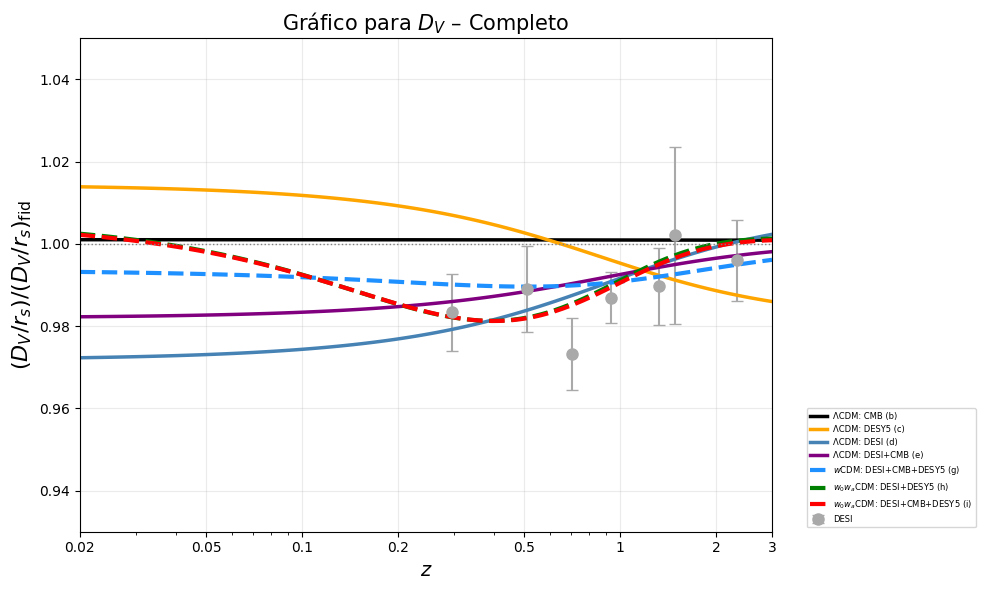

In [31]:
# ============================
#  GRÁFICO Completo para D_V — CORRIGIDO
# ============================

plt.figure(figsize=(10,6))

# =======================
# 1. Normalização fiducial
# =======================

DVfid_norm = DVfid     # já é D_V / r_s

# -------------------------------
# (A) Ponto único D_V observado
# -------------------------------

DV_obs     = DV
err_DV_obs = err_DV
z_DV_obs   = z_DV

DVfid_obs_interp = np.interp(z_DV_obs, z_fid, DVfid)

DV_obs_ratio     = DV_obs / DVfid_obs_interp
DV_obs_err_ratio = err_DV_obs / DVfid_obs_interp

plt.errorbar(
    z_DV_obs, DV_obs_ratio,
    yerr=DV_obs_err_ratio,
    fmt='o',
    color='darkgray',
    ecolor='darkgray',
    markersize=8,
    capsize=4,
    elinewidth=1.5
)

# -------------------------------
# (B) DV calculado via DM e DH
# -------------------------------

DVfid_calc_interp = np.interp(z_DM, z_fid, DVfid)

DV_calc_ratio     = DV_calc / DVfid_calc_interp
DV_calc_err_ratio = sigma_DV / DVfid_calc_interp

plt.errorbar(
    z_DM, DV_calc_ratio,
    yerr=DV_calc_err_ratio,
    fmt='o',
    color='darkgray',
    ecolor='darkgray',
    markersize=8,
    elinewidth=1.5,
    capsize=4,
    label="DESI"
)

# ============================
# 3. Interpolação correta do fiducial
# ============================

DVfid_interp_b = np.interp(z_LCDM_b,   z_fid, DVfid)
DVfid_interp_c = np.interp(z_LCDM_c,   z_fid, DVfid)
DVfid_interp_d = np.interp(z_LCDM_d,   z_fid, DVfid)
DVfid_interp_e = np.interp(z_LCDM_e,   z_fid, DVfid)

DVfid_interp_g = np.interp(z_w0wa_g,   z_fid, DVfid)
DVfid_interp_h = np.interp(z_w0wa_h,   z_fid, DVfid)
DVfid_interp_i = np.interp(z_w0wa_i,   z_fid, DVfid)

# ============================
# 4. Razões corretas
# ============================

DVb_ratio = DVb / DVfid_interp_b
DVc_ratio = DVc / DVfid_interp_c
DVd_ratio = DVd / DVfid_interp_d
DVe_ratio = DVe / DVfid_interp_e

DVg_ratio = DVg / DVfid_interp_g
DVh_ratio = DVh / DVfid_interp_h
DVi_ratio = DVi / DVfid_interp_i

# ============================
# 5. Plot das curvas teóricas
# ============================

plt.plot(z_LCDM_b, DVb_ratio, label='ΛCDM: CMB (b)', color='black', linewidth=2.5)
plt.plot(z_LCDM_c, DVc_ratio, label='ΛCDM: DESY5 (c)', color='orange', linewidth=2.5)
plt.plot(z_LCDM_d, DVd_ratio, label='ΛCDM: DESI (d)', color='steelblue', linewidth=2.5)
plt.plot(z_LCDM_e, DVe_ratio, label='ΛCDM: DESI+CMB (e)', color='purple', linewidth=2.5)

plt.plot(z_w0wa_g, DVg_ratio, label='$w$CDM: DESI+CMB+DESY5 (g)', color='dodgerblue', linestyle="--", linewidth=3)
plt.plot(z_w0wa_h, DVh_ratio, label='$w_0w_a$CDM: DESI+DESY5 (h)', color='green', linestyle="--", linewidth=3)
plt.plot(z_w0wa_i, DVi_ratio, label='$w_0w_a$CDM: DESI+CMB+DESY5 (i)', color='red', linestyle="--", linewidth=3)

# =======================
# 6. Ajustes visuais
# =======================

plt.axhline(1.0, color='gray', linestyle=':', linewidth=1)
plt.xscale('log')

plt.xticks([0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 3],
           ['0.02', '0.05', '0.1', '0.2', '0.5', '1', '2', '3'])

plt.xlabel(r"$z$", fontsize=14)
plt.ylabel(r"$(D_V/r_s) / (D_V/r_s)_{\rm fid}$", fontsize=16)
plt.title("Gráfico para $D_V$ – Completo", fontsize=15)

plt.xlim(0.02, 3)
plt.ylim(0.93, 1.05)

plt.grid(alpha=0.25)

plt.legend(
    fontsize=6,
    bbox_to_anchor=(1.05, 0.25),
    loc="upper left",
    borderaxespad=0.
)

plt.tight_layout()
plt.show()



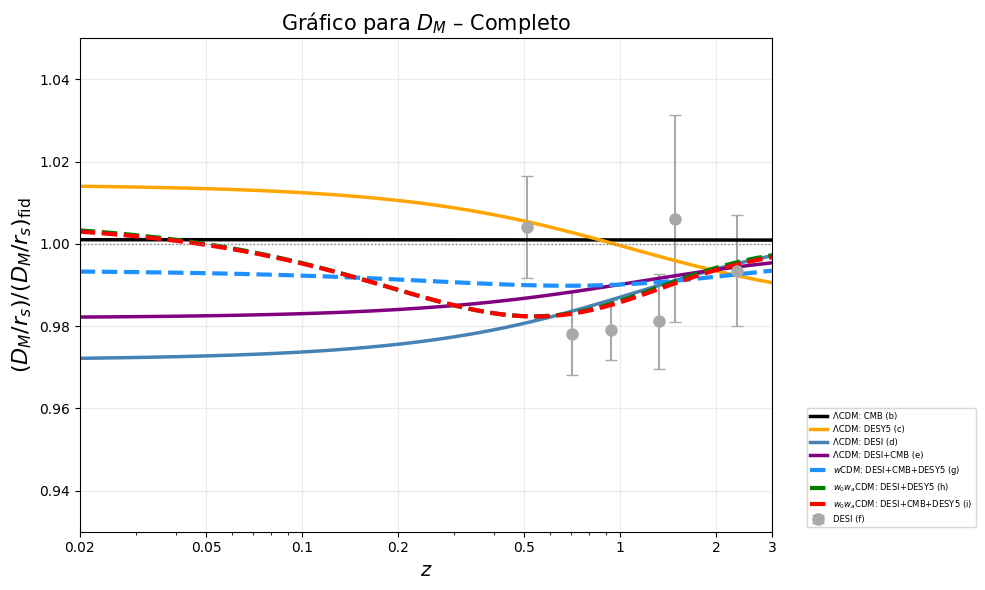

In [33]:
# ============================
#  GRÁFICO Completo para D_M — CORRIGIDO
# ============================

plt.figure(figsize=(10,6))

# =======================
# 1. Normalização fiducial
# =======================

DMfid_norm = DMfid     # já é D_M / r_s

# Interpolação para os pontos DESI
DMfid_interp_DESI = np.interp(z_DM, z_fid, DMfid_norm)

DM_ratio_f     = DM / DMfid_interp_DESI
DM_err_ratio_f = err_DM / DMfid_interp_DESI

# =======================
# 2. Dados DESI (f)
# =======================

plt.errorbar(
    z_DM, DM_ratio_f,
    yerr=DM_err_ratio_f,
    fmt='o',
    color='darkgray',
    ecolor='darkgray',
    elinewidth=1.5,
    capsize=4,
    markersize=8,
    label='DESI (f)'
)

# ============================
# 3. Modelos teóricos — CORRIGIDOS
# ============================

# Interpolação do modelo fiducial nos z de cada curva
DMfid_interp_b = np.interp(z_LCDM_b, z_fid, DMfid_norm)
DMfid_interp_c = np.interp(z_LCDM_c, z_fid, DMfid_norm)
DMfid_interp_d = np.interp(z_LCDM_d, z_fid, DMfid_norm)
DMfid_interp_e = np.interp(z_LCDM_e, z_fid, DMfid_norm)

DMfid_interp_g = np.interp(z_w0wa_g, z_fid, DMfid_norm)
DMfid_interp_h = np.interp(z_w0wa_h, z_fid, DMfid_norm)
DMfid_interp_i = np.interp(z_w0wa_i, z_fid, DMfid_norm)

# Razões corretas
DMb_ratio = DMb / DMfid_interp_b
DMc_ratio = DMc / DMfid_interp_c
DMd_ratio = DMd / DMfid_interp_d
DMe_ratio = DMe / DMfid_interp_e

DMg_ratio = DMg / DMfid_interp_g
DMh_ratio = DMh / DMfid_interp_h
DMi_ratio = DMi / DMfid_interp_i

# Plot das curvas corrigidas
plt.plot(z_LCDM_b, DMb_ratio, label='ΛCDM: CMB (b)', color='black', linewidth=2.5)
plt.plot(z_LCDM_c, DMc_ratio, label='ΛCDM: DESY5 (c)', color='orange', linewidth=2.5)
plt.plot(z_LCDM_d, DMd_ratio, label='ΛCDM: DESI (d)', color='steelblue', linewidth=2.5)
plt.plot(z_LCDM_e, DMe_ratio, label='ΛCDM: DESI+CMB (e)', color='purple', linewidth=2.5)

plt.plot(z_w0wa_g, DMg_ratio, label='$w$CDM: DESI+CMB+DESY5 (g)', color='dodgerblue', linestyle="--", linewidth=3)
plt.plot(z_w0wa_h, DMh_ratio, label='$w_0w_a$CDM: DESI+DESY5 (h)', color='green', linestyle="--", linewidth=3)
plt.plot(z_w0wa_i, DMi_ratio, label='$w_0w_a$CDM: DESI+CMB+DESY5 (i)', color='red', linestyle="--", linewidth=3)

# =======================
# 4. Ajustes visuais
# =======================

plt.axhline(1.0, color='gray', linestyle=':', linewidth=1)
plt.xscale('log')

plt.xticks([0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 3],
           ['0.02', '0.05', '0.1', '0.2', '0.5', '1', '2', '3'])

plt.xlabel(r"$z$", fontsize=14)
plt.ylabel(r"$(D_M/r_s) / (D_M/r_s)_{\rm fid}$", fontsize=16)
plt.title("Gráfico para $D_M$ – Completo", fontsize=15)

plt.xlim(0.02, 3)
plt.ylim(0.93, 1.05)

plt.grid(alpha=0.25)

plt.legend(
    fontsize=6,
    bbox_to_anchor=(1.05, 0.25),
    loc="upper left",
    borderaxespad=0.
)

plt.tight_layout()
plt.show()


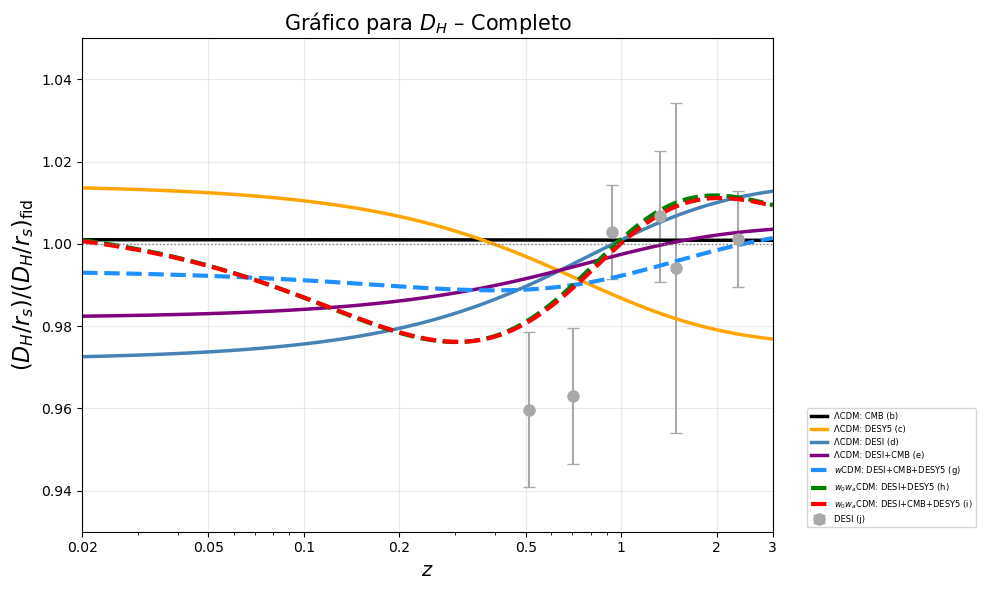